Calculate the Bayes Factor for the stellar mass to determine whether the void and wall samples are drawn from the same or different parent distributions.

In [21]:
from astropy.table import Table
from astropy.io import fits

import numpy as np

import sys

import pickle

import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

import matplotlib
import matplotlib.pyplot as plt

from functions import Model_1_plot, Model_2_plot, uniform, jeffreys, Model_1_fit, Model_2_fit, Model_1_sampler, Model_2_sampler
#from functions_gauss import Model_1_fit, Model_2_fit, Model_1_sampler, Model_2_sampler

np.set_printoptions(threshold=sys.maxsize)

In [2]:
matplotlib.rc('font', size=14)
matplotlib.rc('font', family='DejaVu Sans')

# Data

In [3]:
data_filename = '../../../../data/NSA_v1_0_1_VAGC_vflag-V2-VF.fits'

hdu = fits.open(data_filename)
data = Table(hdu[1].data)
hdu.close()

## Just keep the main SDSS DR7 footprint

In [4]:
# When the catalog is the NSA, only keep those objects which were originally in the DR7 LSS
catalog_SDSS = data[data['IN_DR7_LSS'] == 1]

ra_boolean = np.logical_and(catalog_SDSS['RA'] > 110, catalog_SDSS['RA'] < 270)
catalog_north = catalog_SDSS[ra_boolean]

strip_boolean = np.logical_and.reduce([catalog_north['RA'] > 250, 
                                       catalog_north['RA'] < 269, 
                                       catalog_north['DEC'] > 51, 
                                       catalog_north['DEC'] < 67])
catalog_main = catalog_north[~strip_boolean]

In [5]:
################################################################################
# stellar mass
#-------------------------------------------------------------------------------
Mstar_NSA = np.log10(catalog_main['ELPETRO_MASS'])
################################################################################

'''
################################################################################
# color
#-------------------------------------------------------------------------------
u_r_NSA = np.array(catalog_main['u_r'])

g_r_NSA = np.array(catalog_main['g_r'])
################################################################################


################################################################################
# absolute magnitude
#-------------------------------------------------------------------------------
rabsmag_NSA = np.array(catalog_main['ELPETRO_ABSMAG'][:,4])
################################################################################


################################################################################
# star formation rate and specific SPR
#-------------------------------------------------------------------------------
SFR  = np.array(catalog_main['SFR'])

sSFR = np.array(catalog_main['sSFR'])
################################################################################
''';

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_57880/3681242741.py:4: RuntimeWarning: divide by zero encountered in log10
  Mstar_NSA = np.log10(catalog_main['ELPETRO_MASS'])


## Separate galaxies by their LSS classifications

### $V^2$

In [6]:
wall_v2 = catalog_main['vflag_V2'] == 0
void_v2 = catalog_main['vflag_V2'] == 1
edge_v2 = catalog_main['vflag_V2'] == 2
out_v2 = catalog_main['vflag_V2'] == 9

### VoidFinder

In [7]:
wall_vf = catalog_main['vflag_VF'] == 0
void_vf = catalog_main['vflag_VF'] == 1
edge_vf = catalog_main['vflag_VF'] == 2
out_vf = catalog_main['vflag_VF'] == 9

# Fit the distributions with skewnormal distributions

Both one- and two-parent models

In [8]:
labels1_uni = ['s', 'a', r'$\mu$', r'$\sigma$', 'skew']
labels2_uni = ['a', r'$\mu_a$', r'$\sigma_a$', 'skew$_a$', 'b', r'$\mu_b$', r'$\sigma_b$', 'skew$_b$']

In [9]:
labels1_bi = ['s', 'a', r'$\mu_a$', r'$\sigma_a$', 'skew$_a$', 
                    'b', r'$\mu_b$', r'$\sigma_b$', 'skew$_b$']
labels2_bi = ['$a_1$', r'$\mu_{1a}$', r'$\sigma_{1a}$', 'skew$_{1a}$', 
               '$b_1$', r'$\mu_{1b}$', r'$\sigma_{1b}$', 'skew$_{1b}$', 
               '$a_2$', r'$\mu_{2a}$', r'$\sigma_{2a}$', 'skew$_{2a}$', 
               '$b_2$', r'$\mu_{2b}$', r'$\sigma_{2b}$', 'skew$_{2b}$']

## $M_*$

This is a unimodal distribution

In [10]:
#Mstar_bins = np.linspace(5.9, 12, 135)
Mstar_bins = np.arange(7.5, 11.5, 0.1)

### 1-parent model

In [11]:
'''
Mstar_fit_bounds1 = [[0.001, 10],   # s ...... Gaussian 1 to 2 scale factor
                     [1000, 50000], # a ...... Gaussian amplitude
                     [10, 11],      # mu ..... Gaussian location
                     [0.5, 1],      # sigma .. Gaussian scale
                     [-5, 0]]       # skew ... Gaussian skew
'''
Mstar_fit_bounds1 = [[0.1, 10],    # s ........ Gaussian 1 to 2 scale factor
                     [10, 10000],  # a ........ Gaussian a amplitude
                     [8, 10.45],      # mu_a ..... Gaussian a location
                     [1e-5, 2],    # sigma_a .. Gaussian a scale
                     [-5, 5],      # skew_a ... Gaussian a skew
                     [500, 50000], # b ........ Gaussian b amplitude
                     [10.45, 11],    # mu_b ..... Gaussian b location
                     [1e-5, 2],    # sigma_b .. Gaussian b scale
                     [-5, 5]]      # skew_b ... Gaussian b skew

V2_Mstar_bestfit1 = Model_1_fit(Mstar_fit_bounds1, 
                                Mstar_NSA[wall_v2], 
                                Mstar_NSA[void_v2], 
                                Mstar_bins, 
                                2, 
                                #p0=[2.29, 4640, 10.54, 0.73, -2.93]
                               )

VF_Mstar_bestfit1 = Model_1_fit(Mstar_fit_bounds1, 
                                Mstar_NSA[wall_vf], 
                                Mstar_NSA[void_vf], 
                                Mstar_bins, 
                                2, 
                                #p0=[0.36, 10645, 10.5, 0.74, -2.97]
                               )

running minimizer...this might take a few minutes...
running minimizer...this might take a few minutes...


In [12]:
V2_Mstar_bestfit1

      fun: 943.3051520749942
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.13529951e+00,  8.50386539e-03, -3.90975824e+00, -7.03929573e+00,
       -1.27325848e+00,  1.65075034e-02, -1.31189143e+01,  1.51361177e+01,
       -3.75280254e-01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2140
      nit: 155
     njev: 214
   status: 0
  success: True
        x: array([ 2.41170148e+00,  3.59504931e+03,  1.03756627e+01,  3.67610953e-01,
       -1.09162561e+00,  6.63160367e+03,  1.05355488e+01,  9.54295564e-01,
       -2.56877455e+00])

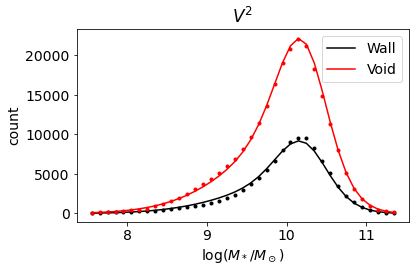

In [13]:
Model_1_plot(V2_Mstar_bestfit1.x, 
             Mstar_NSA[wall_v2], 
             Mstar_NSA[void_v2], 
             Mstar_bins, 
             2, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='$V^2$')

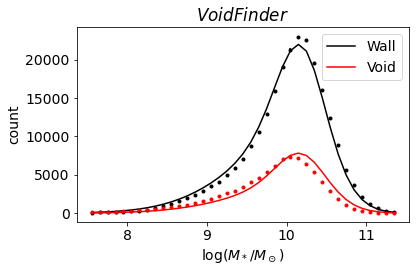

In [14]:
Model_1_plot(VF_Mstar_bestfit1.x, 
             Mstar_NSA[wall_vf], 
             Mstar_NSA[void_vf], 
             np.arange(7.5, 11.5, 0.1), 
             2, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='$VoidFinder$')

In [15]:
VF_Mstar_bestfit1

      fun: 4214.01561572131
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.17753337, -0.03656207, -0.57079883,  0.1715307 ,  0.99480531,
       -0.01955256,  0.5748006 , -0.31868694,  0.4989488 ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2390
      nit: 170
     njev: 239
   status: 0
  success: True
        x: array([ 3.55993197e-01,  8.14005612e+03,  1.03543204e+01,  3.56182001e-01,
       -1.03023142e+00,  1.61244929e+04,  1.05406695e+01,  9.42447594e-01,
       -2.62686455e+00])

#### Nested sampling of Likelihood and Priors

In [35]:
def prior_xform1_uni_V2(u):
    '''
    Priors for the 5 parameters of unimodel M1.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    '''
    s = uniform(0.1, 5, u[0])
    a = jeffreys(1000, 50000, u[1])
    mu = uniform(9, 11, u[2])
    sigma = uniform(0.01, 2, u[3])
    skew = uniform(-5, 5, u[4])

    return s, a, mu, sigma, skew
    '''
    s = uniform(1, 4, u[0])
    a = jeffreys(1000, 10000, u[1])
    mu_a = uniform(9.5, 10.45, u[2])
    sigma_a = uniform(0.1, 2, u[3])
    skew_a = uniform(-4, 0, u[4])
    b = jeffreys(1000, 10000, u[5])
    mu_b = uniform(10.45, 11, u[6])
    sigma_b = uniform(0.1, 2, u[7])
    skew_b = uniform(-4, 0, u[8])

    return s, a, mu_a, sigma_a, skew_a, b, mu_b, sigma_b, skew_b

In [36]:
Model_1_sampler(prior_xform1_uni_V2, 
                Mstar_NSA[wall_v2], 
                Mstar_NSA[void_v2], 
                Mstar_bins, 
                2, 
                '_Mstar_V2')

running the nested sampler... this might take from minutes to hours...


36374it [31:30, 19.24it/s, batch: 7 | bound: 1895 | nc: 10 | ncall: 1662209 | eff(%):  2.188 | loglstar: -952.752 < -943.722 < -945.316 | logz: -983.441 +/-  0.370 | stop:  0.982]           


sampler output saved as pickle file 'dynesty_output/sampler_results_model1_Mstar_V2'


In [16]:
#temp_infile = open('dynesty_output/sampler_results_model1_gauss_Mstar_V2.pickle', 'rb')
temp_infile = open('dynesty_output/sampler_results_model1_Mstar_V2.pickle', 'rb')
dres1_V2_Mstar = pickle.load(temp_infile)
temp_infile.close()

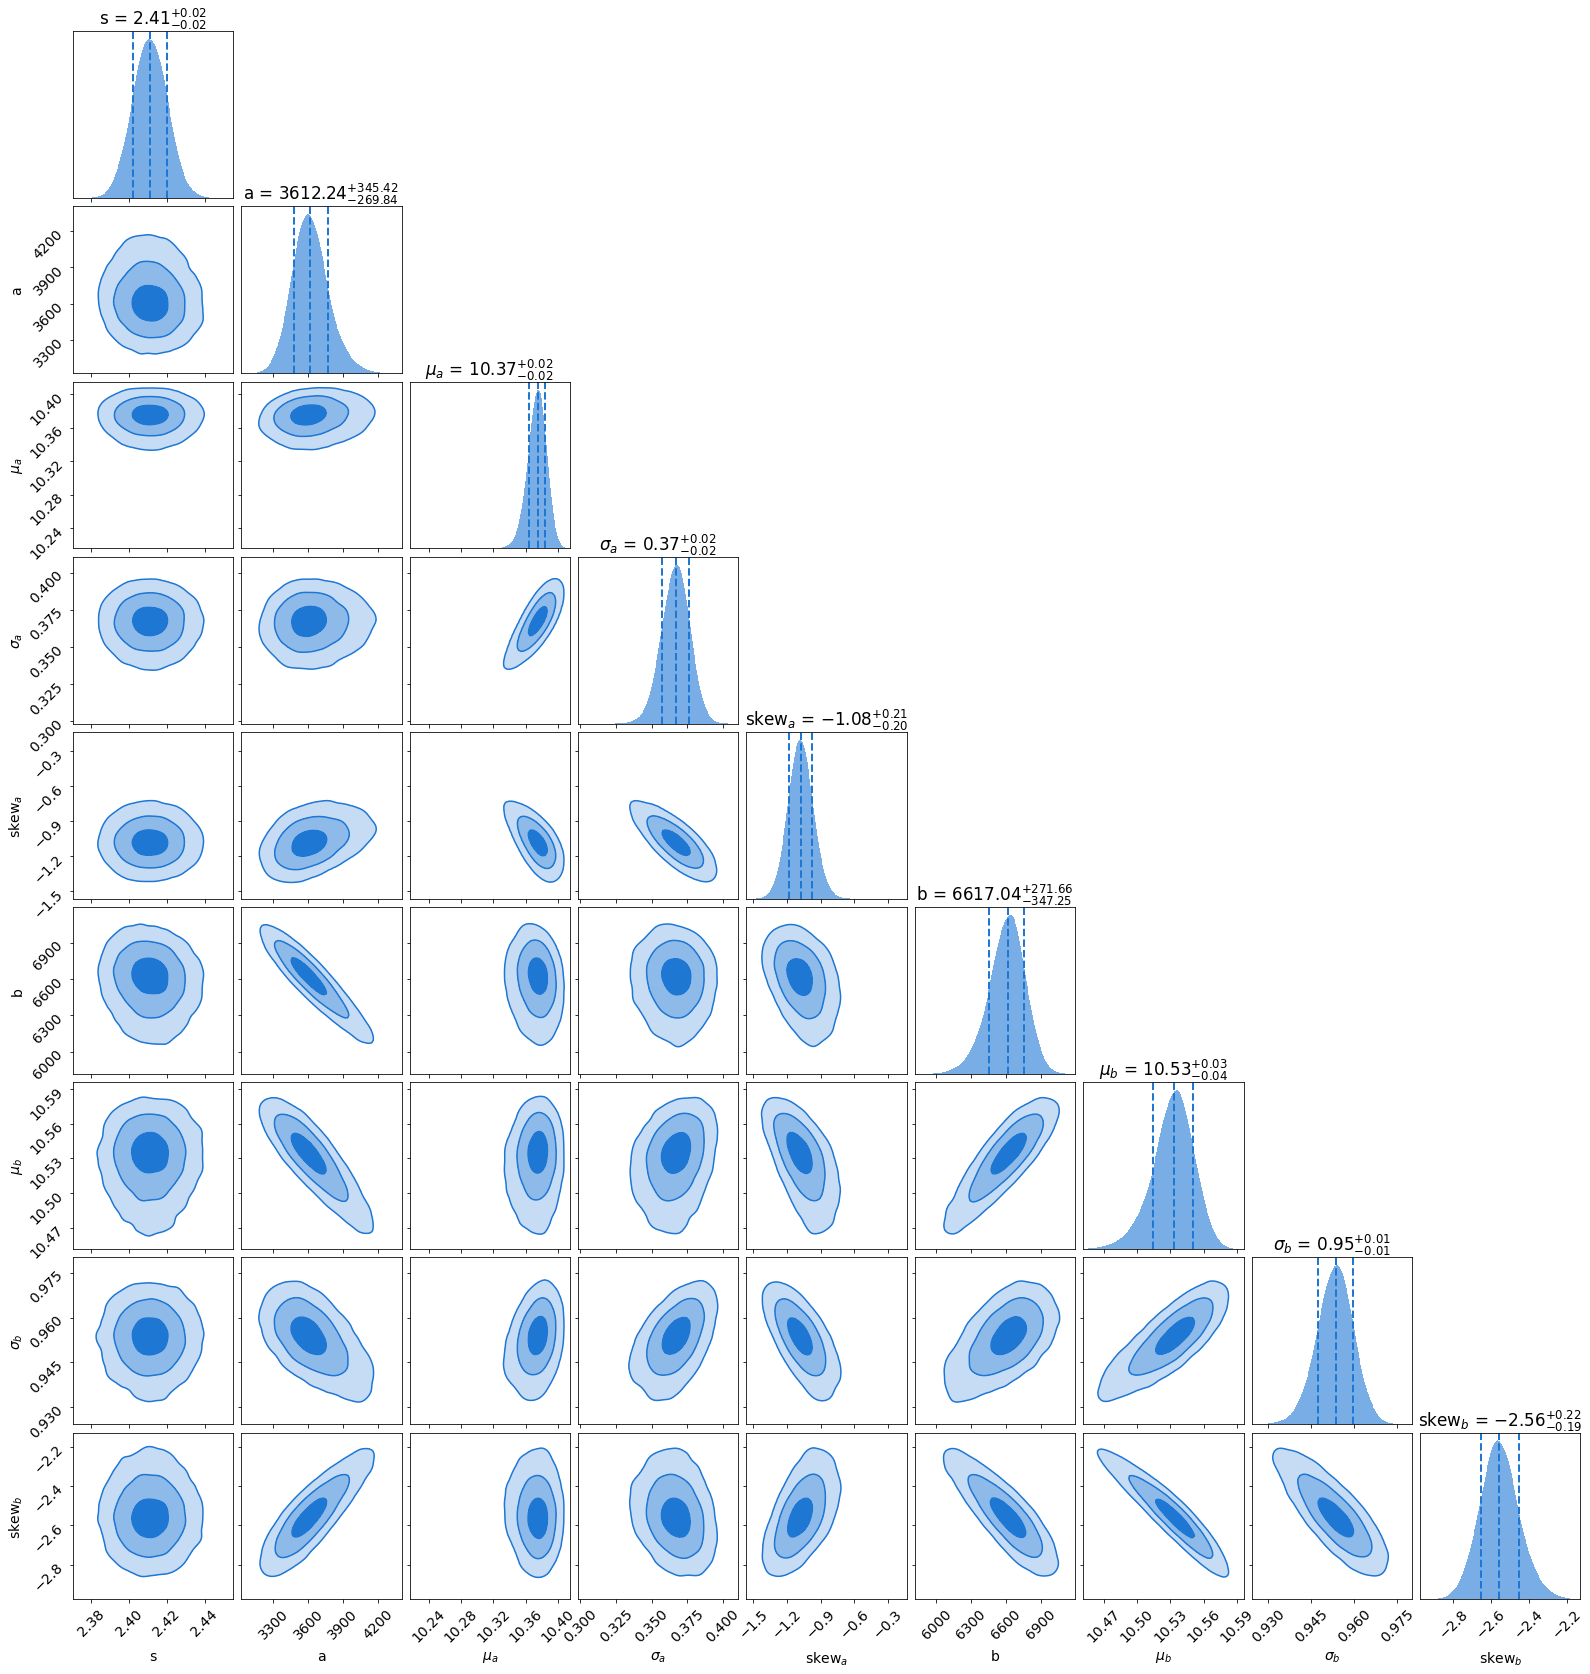

In [38]:
fig, axes = dyplot.cornerplot(dres1_V2_Mstar, smooth=0.03, 
                              labels=labels1_bi, 
                              #labels=labels1_uni, 
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(9, 9, figsize=(2.5*9, 2.6*9)), 
                              #fig=plt.subplots(5, 5, figsize=(2.5*5, 2.6*5)), 
                              color='#1f77d4')

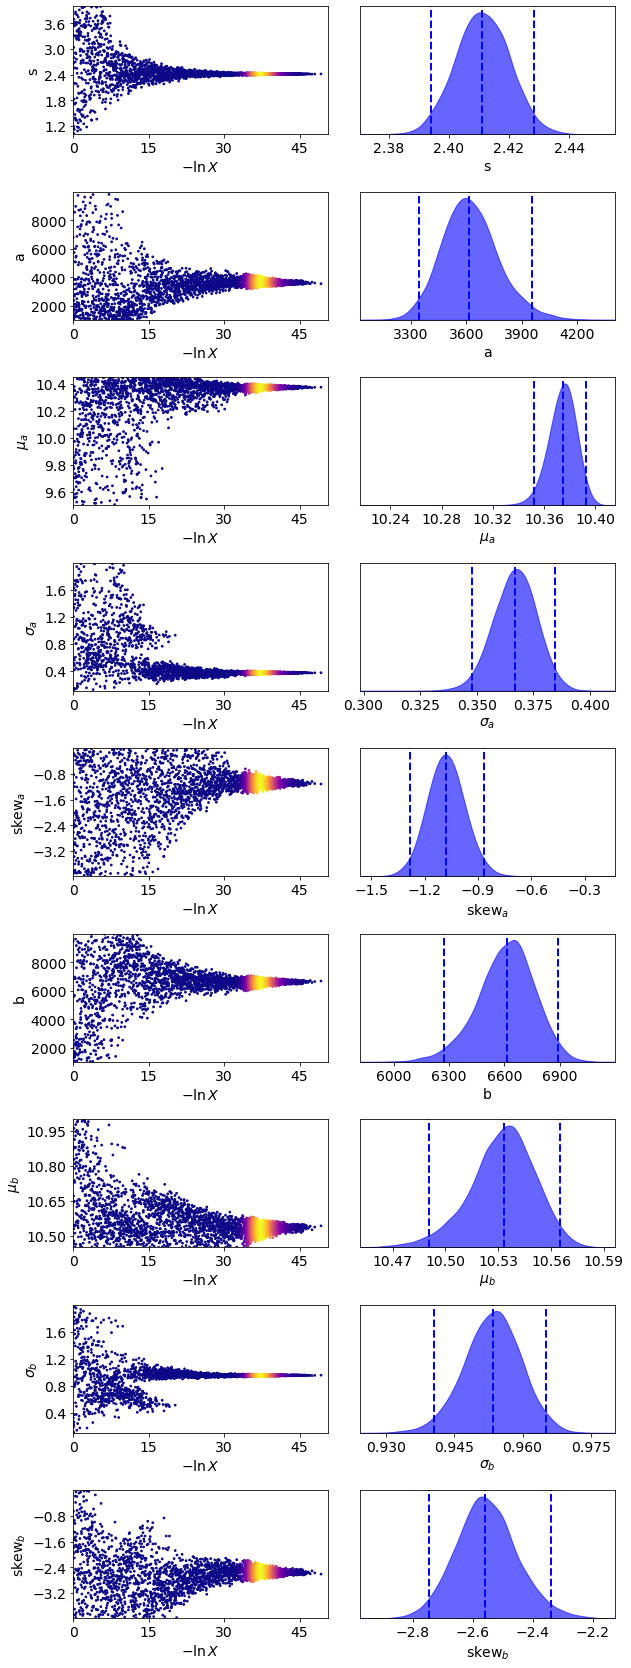

In [20]:
n_params = len(labels1_bi)

fig, axes = dyplot.traceplot(dres1_V2_Mstar, 
                             labels=labels1_bi, 
                             fig=plt.subplots(n_params, 2, figsize=(n_params, 2.6*n_params)), 
                             thin=10)

fig.tight_layout();

In [23]:
lnzM1_V2_Mstar = dres1_V2_Mstar.logz[-1]
lnzM1_V2_Mstar

-983.4425607452994

In [25]:
V2_Mstar_bestfit1_dynesty,_ = dyfunc.mean_and_cov(dres1_V2_Mstar.samples, 
                                                  np.exp(dres1_V2_Mstar.logwt - lnzM1_V2_Mstar))

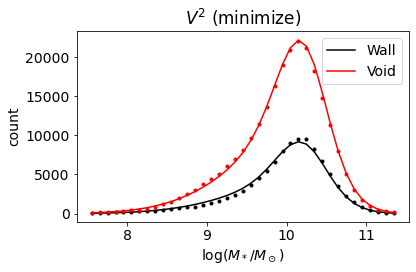

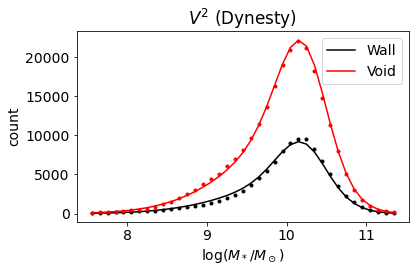

In [26]:
Model_1_plot(V2_Mstar_bestfit1.x, 
             Mstar_NSA[wall_v2], 
             Mstar_NSA[void_v2], 
             Mstar_bins, 
             2, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='$V^2$ (minimize)')

Model_1_plot(V2_Mstar_bestfit1_dynesty, 
             Mstar_NSA[wall_v2], 
             Mstar_NSA[void_v2], 
             Mstar_bins, 
             2, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='$V^2$ (Dynesty)')

In [40]:
def prior_xform1_uni_VF(u):
    '''
    Priors for the 5 parameters of unimodel M1.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''
    
    '''
    s = uniform(0.1, 1, u[0])
    a = jeffreys(8000, 50000, u[1])
    mu = uniform(9, 11, u[2])
    sigma = uniform(0.01, 2, u[3])
    skew = uniform(-5, 5, u[4])

    return s, a, mu, sigma, skew
    '''
    
    s = uniform(0.01, 2, u[0])
    a = jeffreys(1000, 10000, u[1])
    mu_a = uniform(9.5, 10.45, u[2])
    sigma_a = uniform(0.1, 2, u[3])
    skew_a = uniform(-4, 0, u[4])
    b = jeffreys(5000, 50000, u[5])
    mu_b = uniform(10.45, 11, u[6])
    sigma_b = uniform(0.1, 2, u[7])
    skew_b = uniform(-4, 0, u[8])

    return s, a, mu_a, sigma_a, skew_a, b, mu_b, sigma_b, skew_b

In [41]:
Model_1_sampler(prior_xform1_uni_VF, 
                Mstar_NSA[wall_vf], 
                Mstar_NSA[void_vf], 
                Mstar_bins, 
                2, 
                '_Mstar_VoidFinder')

running the nested sampler... this might take from minutes to hours...


36219it [29:57, 20.15it/s, batch: 7 | bound: 1404 | nc: 30 | ncall: 1149975 | eff(%):  3.150 | loglstar: -4221.866 < -4213.098 < -4215.966 | logz: -4253.848 +/-  0.376 | stop:  0.947]      


sampler output saved as pickle file 'dynesty_output/sampler_results_model1_Mstar_VoidFinder'


In [28]:
temp_infile = open('dynesty_output/sampler_results_model1_Mstar_VoidFinder.pickle', 
#temp_infile = open('dynesty_output/sampler_results_model1_gauss_Mstar_VoidFinder.pickle', 
                   'rb')
dres1_VF_Mstar = pickle.load(temp_infile)
temp_infile.close()

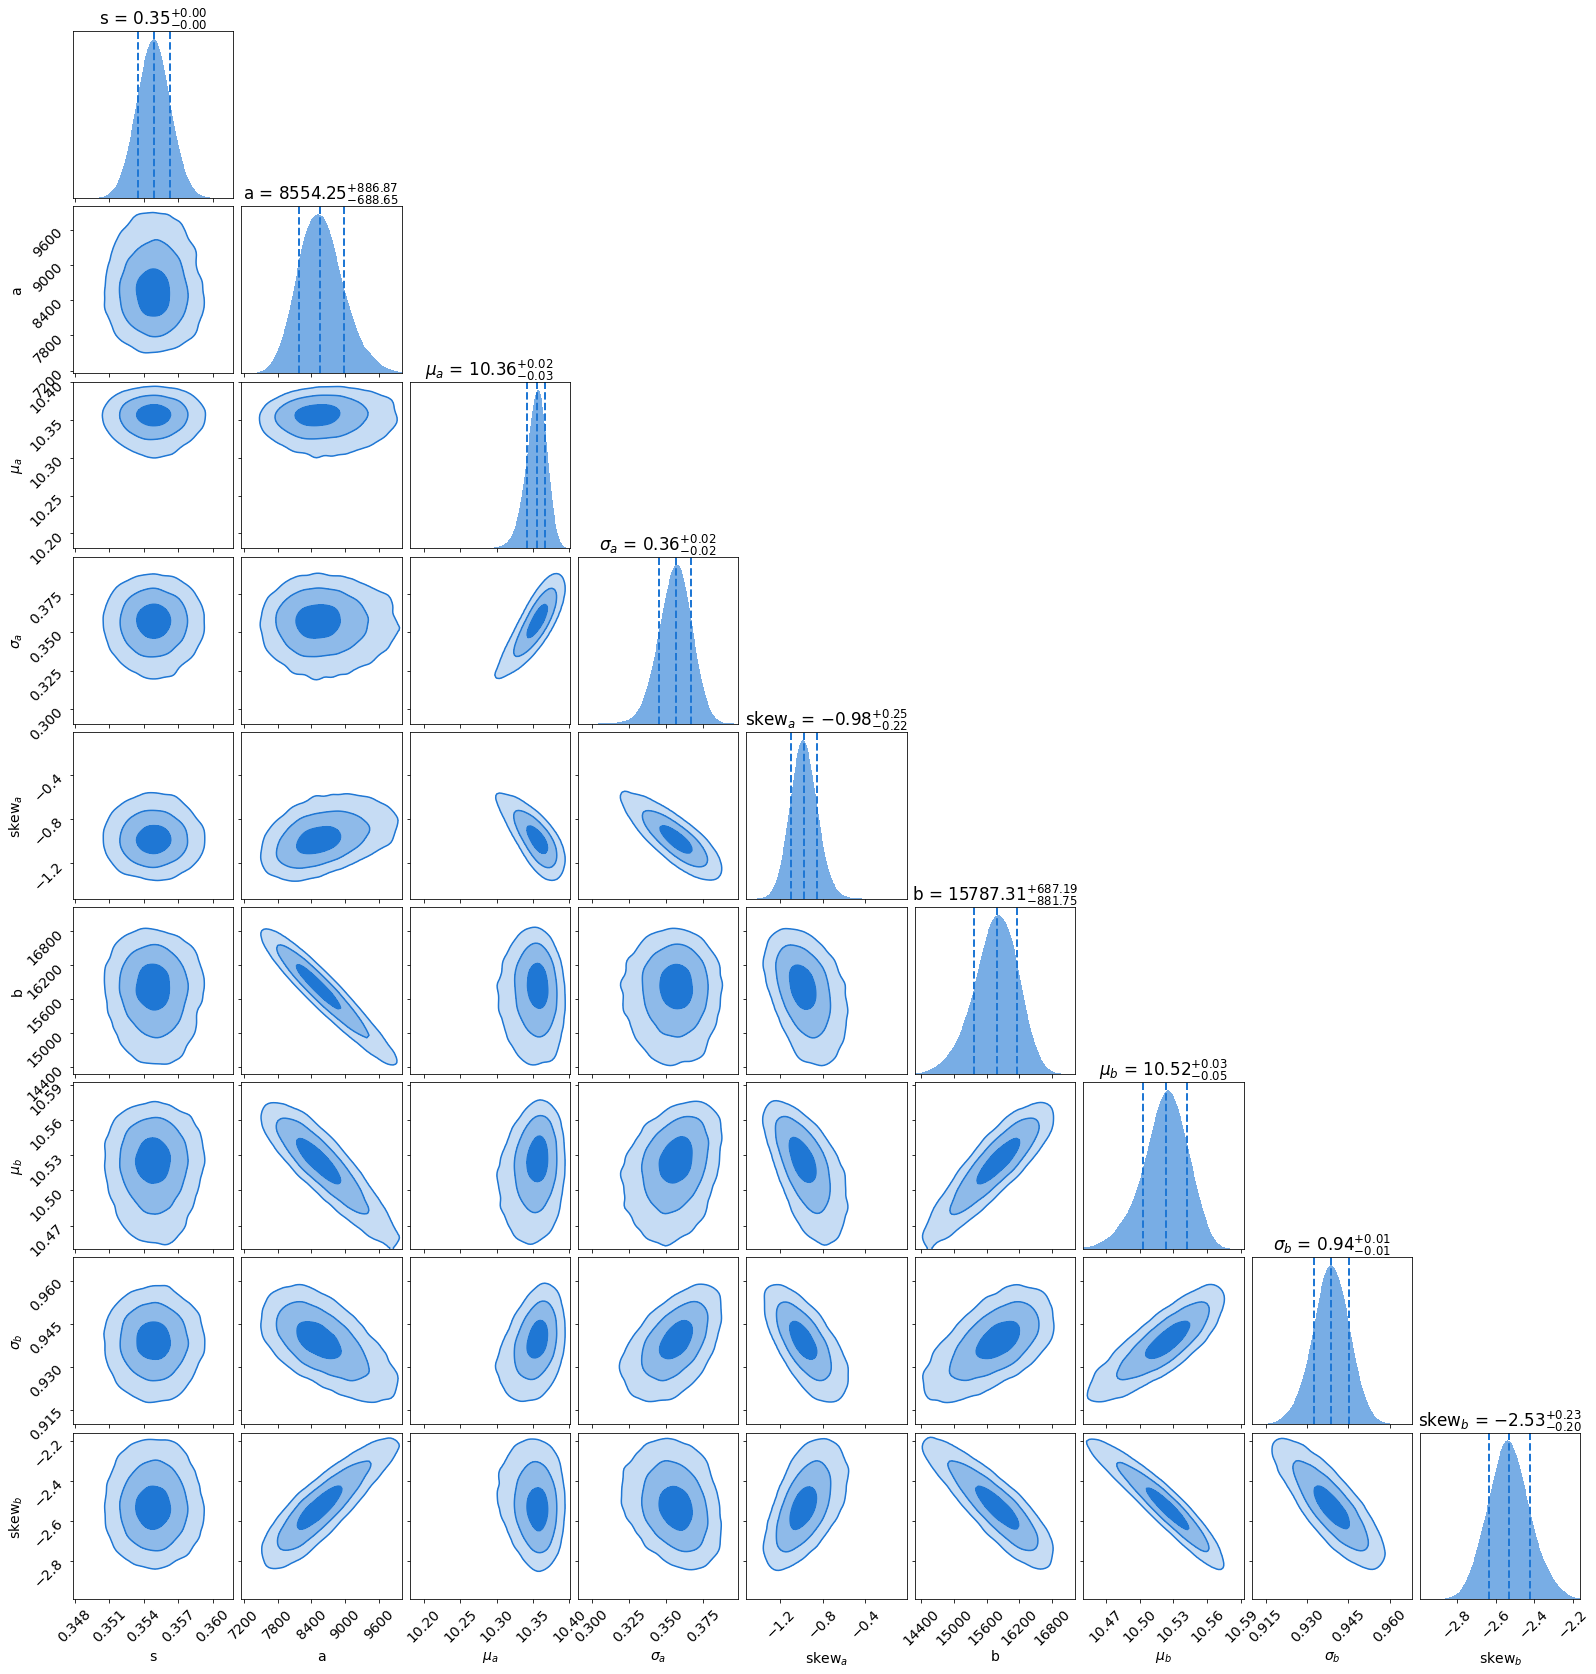

In [43]:
fig, axes = dyplot.cornerplot(dres1_VF_Mstar, smooth=0.03, 
                              labels=labels1_bi, 
                              #labels=labels1_uni, 
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(9, 9, figsize=(2.5*9, 2.6*9)), 
                              #fig=plt.subplots(5, 5, figsize=(2.5*5, 2.6*5)), 
                              color='#1f77d4')

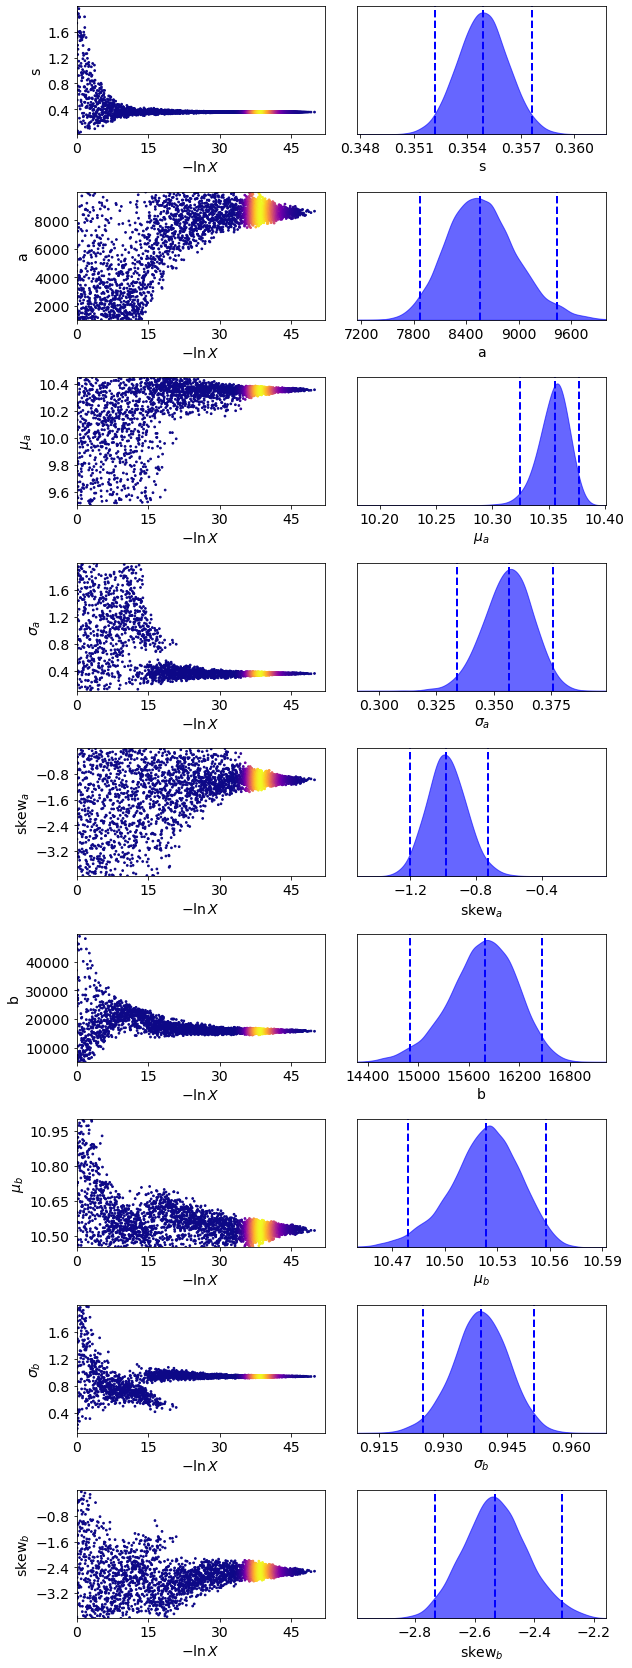

In [29]:
n_params = len(labels1_bi)

fig, axes = dyplot.traceplot(dres1_VF_Mstar, 
                             labels=labels1_bi, 
                             fig=plt.subplots(n_params, 2, figsize=(n_params, 2.6*n_params)), 
                             thin=10)

fig.tight_layout();

In [30]:
lnzM1_VF_Mstar = dres1_VF_Mstar.logz[-1]
lnzM1_VF_Mstar

-4253.842797823419

In [31]:
VF_Mstar_bestfit1_dynesty,_ = dyfunc.mean_and_cov(dres1_VF_Mstar.samples, 
                                                  np.exp(dres1_VF_Mstar.logwt - lnzM1_VF_Mstar))

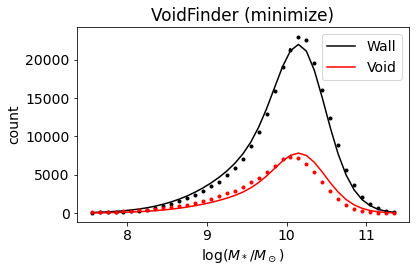

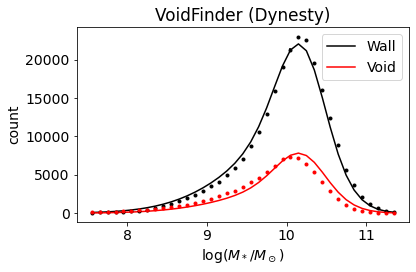

In [32]:
Model_1_plot(VF_Mstar_bestfit1.x, 
             Mstar_NSA[wall_vf], 
             Mstar_NSA[void_vf], 
             Mstar_bins, 
             2, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='VoidFinder (minimize)')

Model_1_plot(VF_Mstar_bestfit1_dynesty, 
             Mstar_NSA[wall_vf], 
             Mstar_NSA[void_vf], 
             Mstar_bins, 
             2, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='VoidFinder (Dynesty)')

### 2-parent model

In [80]:
'''
Mstar_fit_bounds2 = [[2000, 50000], # a ........ Gaussian A amplitude
                     [10, 11],      # mu_a ..... Gaussian A location
                     [0.1, 1],      # sigma_a .. Gaussian A scale
                     [-4, -1],      # skew_a ... Gaussian A skew
                     [3000, 50000], # b ........ Gaussian B amplitude
                     [10, 11],      # mu_b ..... Gaussian B location
                     [0.1, 1],      # sigma_b .. Gaussian B scale
                     [-4, -1]]      # skew_b ... Gaussian B skew
'''
# 1 = wall, 2 = void

Mstar_fit_bounds2 = [[10, 50000],  # a1 ........ Gaussian A1 amplitude
                     [8, 10.75],   # mu_a1 ..... Gaussian A1 location
                     [1e-5, 2],    # sigma_a1 .. Gaussian A1 scale
                     [-10, 10],    # skew_a1 ... Gaussian A1 skew
                     [500, 50000], # b1 ........ Gaussian B1 amplitude
                     [10, 11],     # mu_b1 ..... Gaussian B1 location
                     [1e-5, 2],    # sigma_b1 .. Gaussian B1 scale
                     [-10, 5],     # skew_b1 ... Gaussian B1 skew
                     [100, 50000], # a2 ........ Gaussian A2 amplitude
                     [8, 10.5],    # mu_a2 ..... Gaussian A2 location
                     [1e-5, 2],    # sigma_a2 .. Gaussian A2 scale
                     [-10, 10],    # skew_a2 ... Gaussian A2 skew
                     [500, 50000], # b2 ........ Gaussian B2 amplitude
                     [10, 11],     # mu_b2 ..... Gaussian B2 location
                     [1e-5, 2],    # sigma_b2 .. Gaussian B2 scale
                     [-5, 5]]      # skew_b2 ... Gaussian B2 skew

V2_Mstar_bestfit2 = Model_2_fit(Mstar_fit_bounds2, 
                                Mstar_NSA[wall_v2], 
                                Mstar_NSA[void_v2], 
                                Mstar_bins, 
                                2, 
                                #p0=[4640, 10.54, 0.73, -2.91, 10624, 10.54, 0.74, -2.95]
                                #p0=[2300, 9.00, 0.91, 0.68, 8026, 10.47, 0.52, -1.61, 12545, 10.00, 0.39, 0.98, 12272, 10.22, 0.84, -1.70], 
                               )

Mstar_fit_bounds2 = [[10, 50000],  # a1 ........ Gaussian A1 amplitude
                     [8, 10.75],   # mu_a1 ..... Gaussian A1 location
                     [1e-5, 2],    # sigma_a1 .. Gaussian A1 scale
                     [-10, 10],    # skew_a1 ... Gaussian A1 skew
                     [500, 50000], # b1 ........ Gaussian B1 amplitude
                     [10, 11],     # mu_b1 ..... Gaussian B1 location
                     [1e-5, 2],    # sigma_b1 .. Gaussian B1 scale
                     [-10, 5],     # skew_b1 ... Gaussian B1 skew
                     [100, 50000], # a2 ........ Gaussian A2 amplitude
                     [8, 10.5],    # mu_a2 ..... Gaussian A2 location
                     [1e-5, 2],    # sigma_a2 .. Gaussian A2 scale
                     [-10, 10],    # skew_a2 ... Gaussian A2 skew
                     [500, 50000], # b2 ........ Gaussian B2 amplitude
                     [9.5, 11],    # mu_b2 ..... Gaussian B2 location
                     [1e-5, 2],    # sigma_b2 .. Gaussian B2 scale
                     [-5, 5]]      # skew_b2 ... Gaussian B2 skew

VF_Mstar_bestfit2 = Model_2_fit(Mstar_fit_bounds2, 
                                Mstar_NSA[wall_vf], 
                                Mstar_NSA[void_vf], 
                                Mstar_bins, 
                                2, 
                                #p0=[10645, 10.53, 0.68, -2.53, 3808, 10.46, 0.81, -3.41]
                               )

running minimizer...this might take a few minutes...
running minimizer...this might take a few minutes...


In [81]:
V2_Mstar_bestfit2

      fun: 502.66229797886893
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.65779900e-02,  2.99654605e+00, -1.28310945e+01, -5.38220778e+00,
       -3.89267849e-02,  1.28739760e+01,  6.96766165e+00,  3.80728127e+00,
        2.48044744e-02, -2.70794522e+01, -3.72813361e+01,  2.96506643e+00,
        2.61345035e-02, -7.34163389e+00, -6.80309423e+00,  3.48351252e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 11832
      nit: 547
     njev: 696
   status: 0
  success: True
        x: array([ 3.67885098e+03,  1.04262722e+01,  1.06195702e+00, -2.02874206e+00,
        6.52275951e+03,  1.04410782e+01,  4.61168127e-01, -1.39741734e+00,
        1.39278168e+04,  1.00036821e+01,  4.05409874e-01,  1.11006446e+00,
        1.07929308e+04,  1.01286681e+01,  8.12635743e-01, -2.41015879e+00])

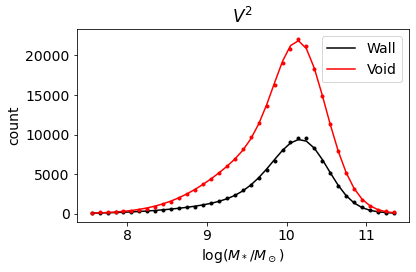

In [168]:
Model_2_plot(V2_Mstar_bestfit2.x, 
             Mstar_NSA[wall_v2], 
             Mstar_NSA[void_v2], 
             Mstar_bins, 
             2, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='$V^2$')

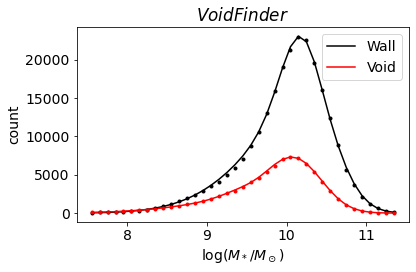

In [83]:
Model_2_plot(VF_Mstar_bestfit2.x, 
             Mstar_NSA[wall_vf], 
             Mstar_NSA[void_vf], 
             Mstar_bins, 
             2, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='$VoidFinder$')

In [84]:
VF_Mstar_bestfit2

      fun: 538.4035805085575
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.51341519e-03, -3.44441531e+00, -9.05114348e+00, -3.80077834e-01,
        9.10672063e-02, -2.51159215e+00, -5.77971375e+00, -6.52869407e-01,
        4.97726239e-02, -4.93562270e+00, -1.53050905e+00, -2.05067182e+00,
        6.24488404e-02,  3.06956710e+00,  4.04963883e-01,  8.99308367e-01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 11730
      nit: 534
     njev: 690
   status: 0
  success: True
        x: array([ 5.19535436e+03,  1.02973410e+01,  2.80420687e-01, -9.30812447e-01,
        1.92970442e+04,  1.06174973e+01,  8.84122716e-01, -2.88613222e+00,
        7.10350195e+03,  1.03512334e+01,  5.25609405e-01, -1.46020327e+00,
        1.59037064e+03,  9.51012185e+00,  8.07230931e-01, -4.44907369e+00])

#### Nested sampling of Likelihood and Priors

##### V$^2$

In [175]:
def prior_xform2_uni_V2(u):
    '''
    Priors for the 8 parameters of unimodel M2.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    a1 = jeffreys(1000, 5000, u[0])
    mu_a1 = uniform(9, 10.439, u[1])
    sigma_a1 = uniform(0.1, 2, u[2])
    skew_a1 = uniform(-5, 0, u[3])

    b1 = jeffreys(3000, 9000, u[4])
    mu_b1 = uniform(10.439, 11, u[5])
    sigma_b1 = uniform(0.01, 1, u[6])
    skew_b1 = uniform(-5, 0, u[7])
    
    a2 = jeffreys(1000, 20000, u[8])
    mu_a2 = uniform(8, 10.05, u[9])
    sigma_a2 = uniform(0.01, 1, u[10])
    skew_a2 = uniform(-5, 5, u[11])

    b2 = jeffreys(1000, 20000, u[12])
    mu_b2 = uniform(10.05, 11, u[13])
    sigma_b2 = uniform(0.01, 1.5, u[14])
    skew_b2 = uniform(-5, 5, u[15])

    return a1, mu_a1, sigma_a1, skew_a1, b1, mu_b1, sigma_b1, skew_b1, \
           a2, mu_a2, sigma_a2, skew_a2, b2, mu_b2, sigma_b2, skew_b2

In [176]:
Model_2_sampler(prior_xform2_uni_V2, 
                Mstar_NSA[wall_v2], 
                Mstar_NSA[void_v2], 
                Mstar_bins, 
                2, 
                '_Mstar_V2')

running the nested sampler... this might take from minutes to hours...


12826it [03:45, 48.32it/s, batch: 0 | bound: 159 | nc: 25 | ncall: 294218 | eff(%):  4.352 | loglstar:   -inf < -1615.875 <    inf | logz: -1647.275 +/-  0.347 | dlogz: 620.594 >  0.010]   /Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
12831it [03:46, 21.57it/s, batch: 0 | bound: 160 | nc: 28 | ncall: 294924 | eff(%):  4.343 | loglstar:   -inf < -1614.702 <    inf | logz: -1645.229 +/-  0.346 | dlogz: 618.297 >  0.010]/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
13158it [03:53, 52.35it/s, batch: 0 | bound: 165 | nc: 25 | ncall: 304621 | eff(%):  4.312 | loglstar:   -inf <

sampler output saved as pickle file 'dynesty_output/sampler_results_model2_Mstar_V2'


In [177]:
#temp_infile = open('dynesty_output/sampler_results_model2_gauss_Mstar_V2.pickle', 'rb')
temp_infile = open('dynesty_output/sampler_results_model2_Mstar_V2.pickle', 'rb')
dres2_V2_Mstar = pickle.load(temp_infile)
temp_infile.close()

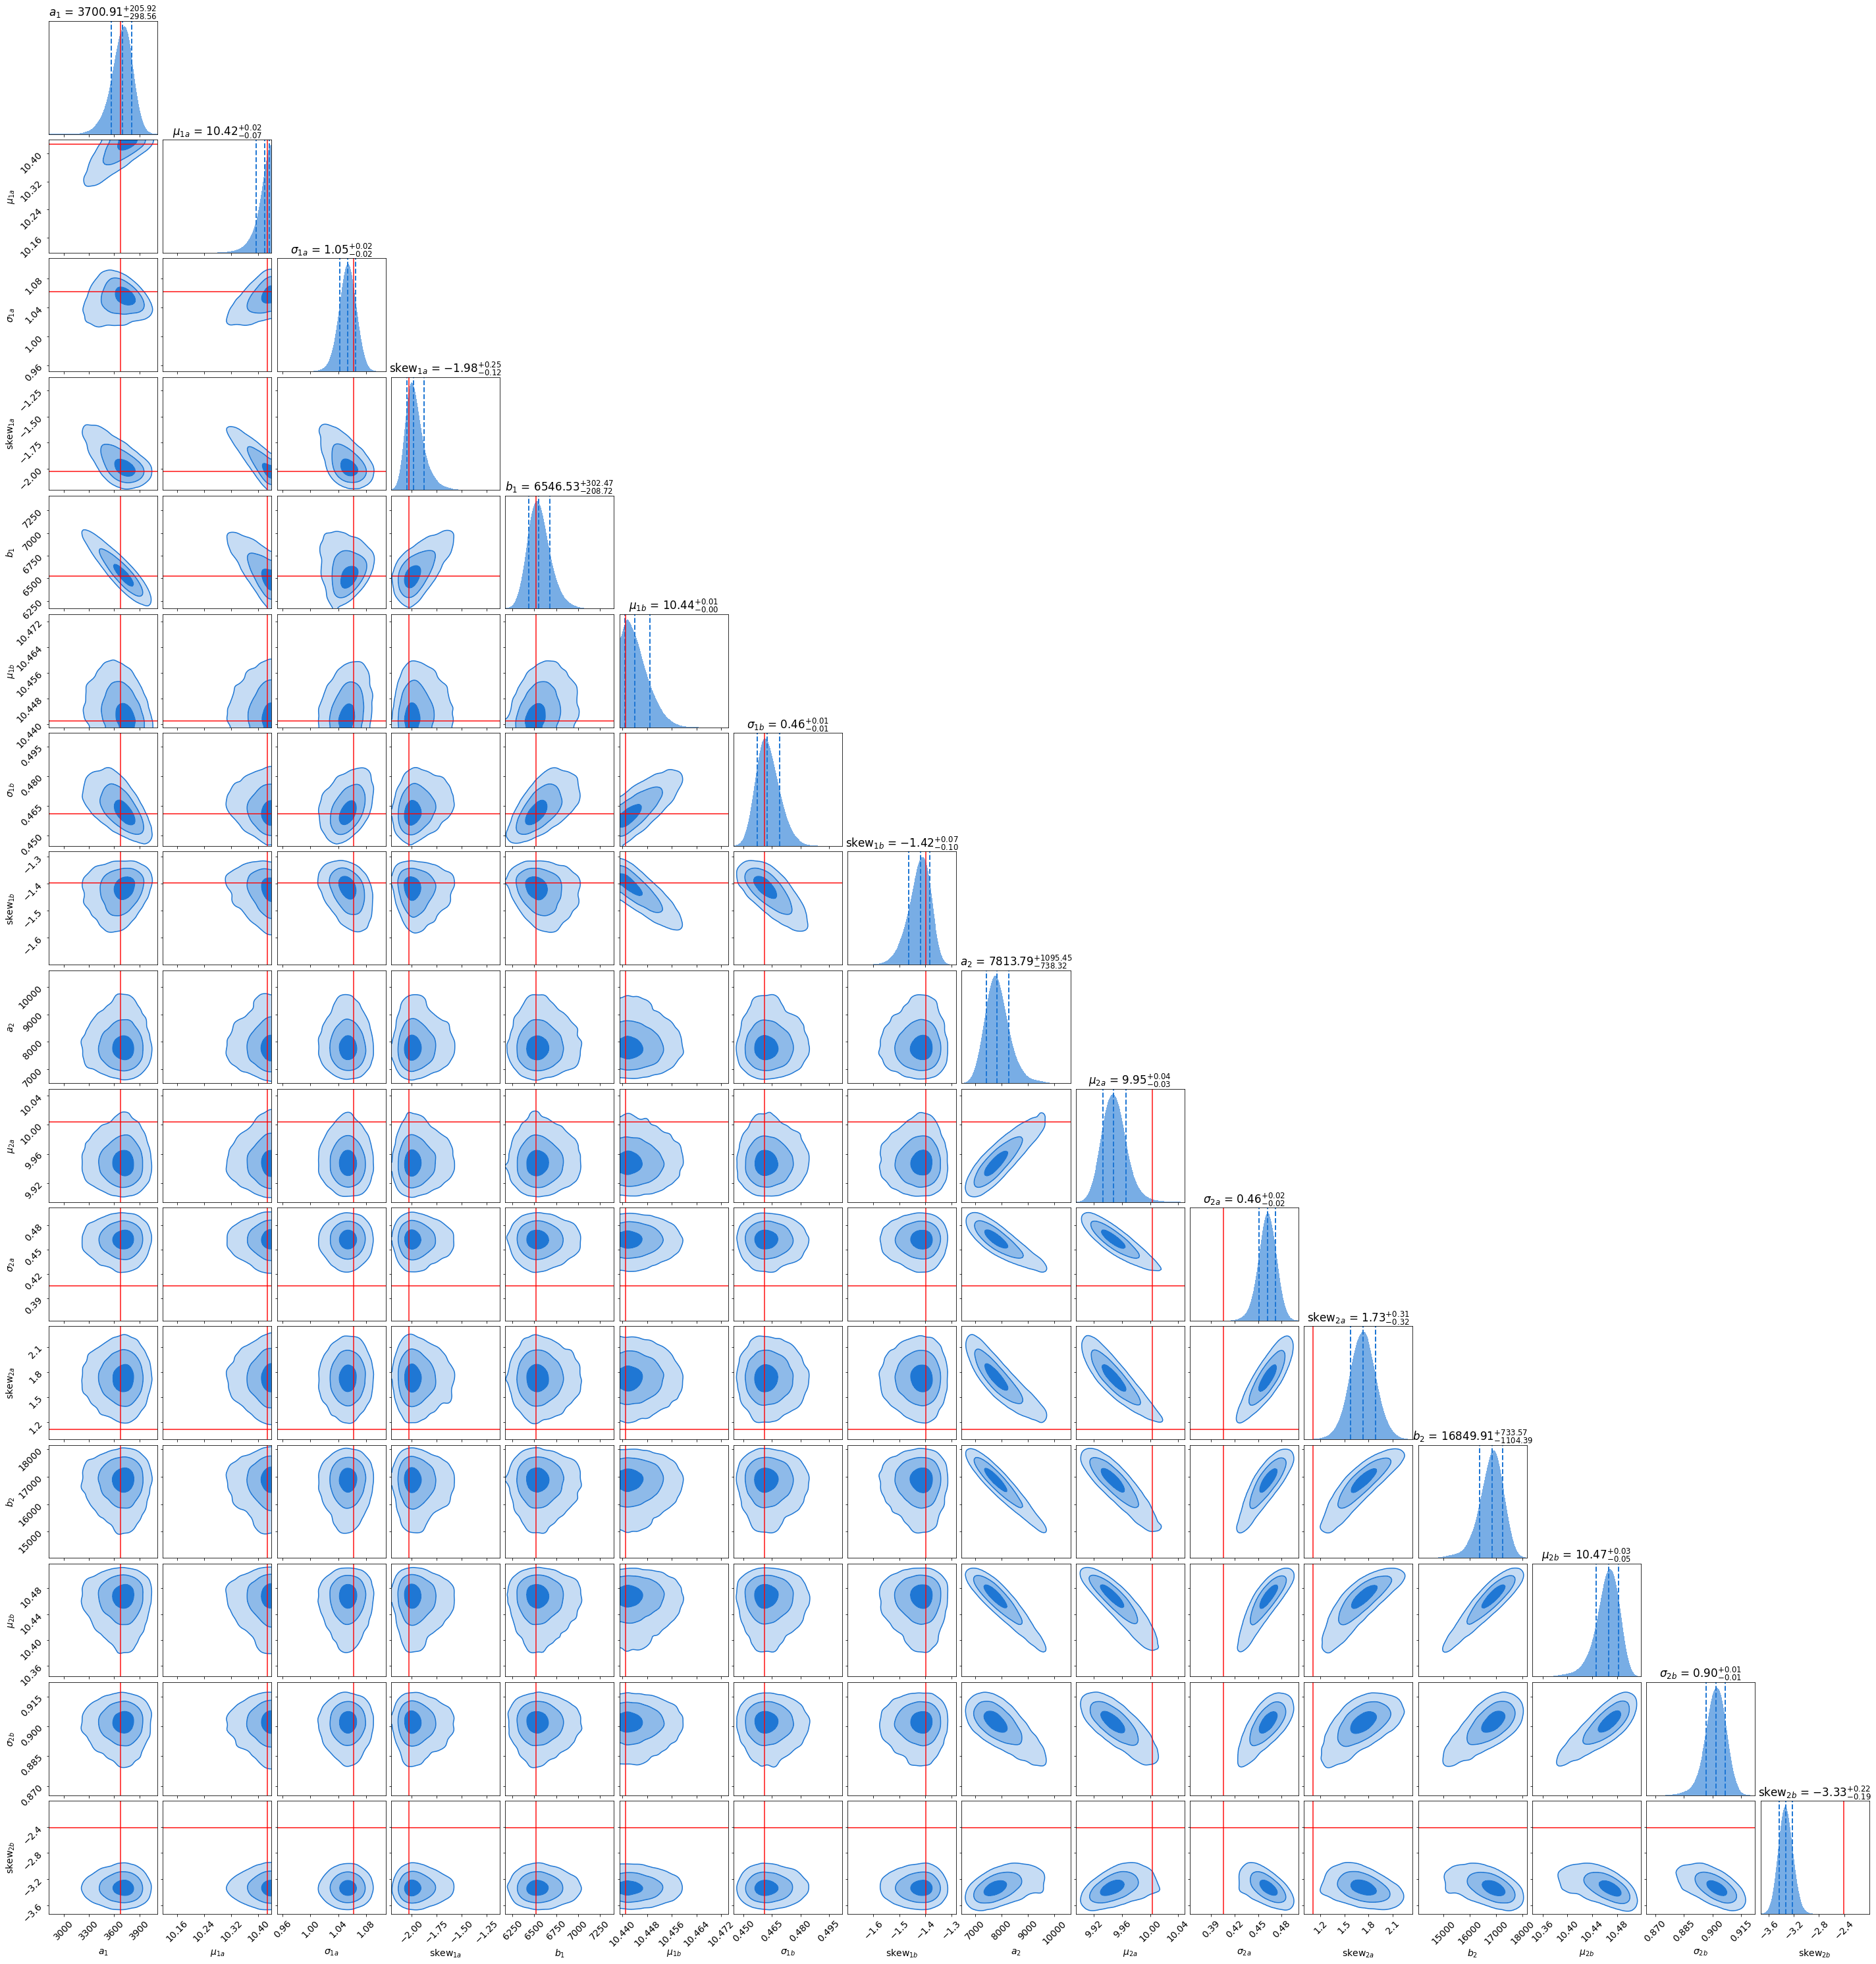

In [178]:
n_params = len(labels2_bi)

fig, axes = dyplot.cornerplot(dres2_V2_Mstar, smooth=0.03, 
                              labels=labels2_bi, 
                              #labels=labels2_uni, 
                              show_titles=True, 
                              truths=V2_Mstar_bestfit2.x,
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(n_params, n_params, figsize=(2.5*n_params, 2.6*n_params)), 
                              #fig=plt.subplots(8, 8, figsize=(2.5*8, 2.6*8)), 
                              color='#1f77d4')

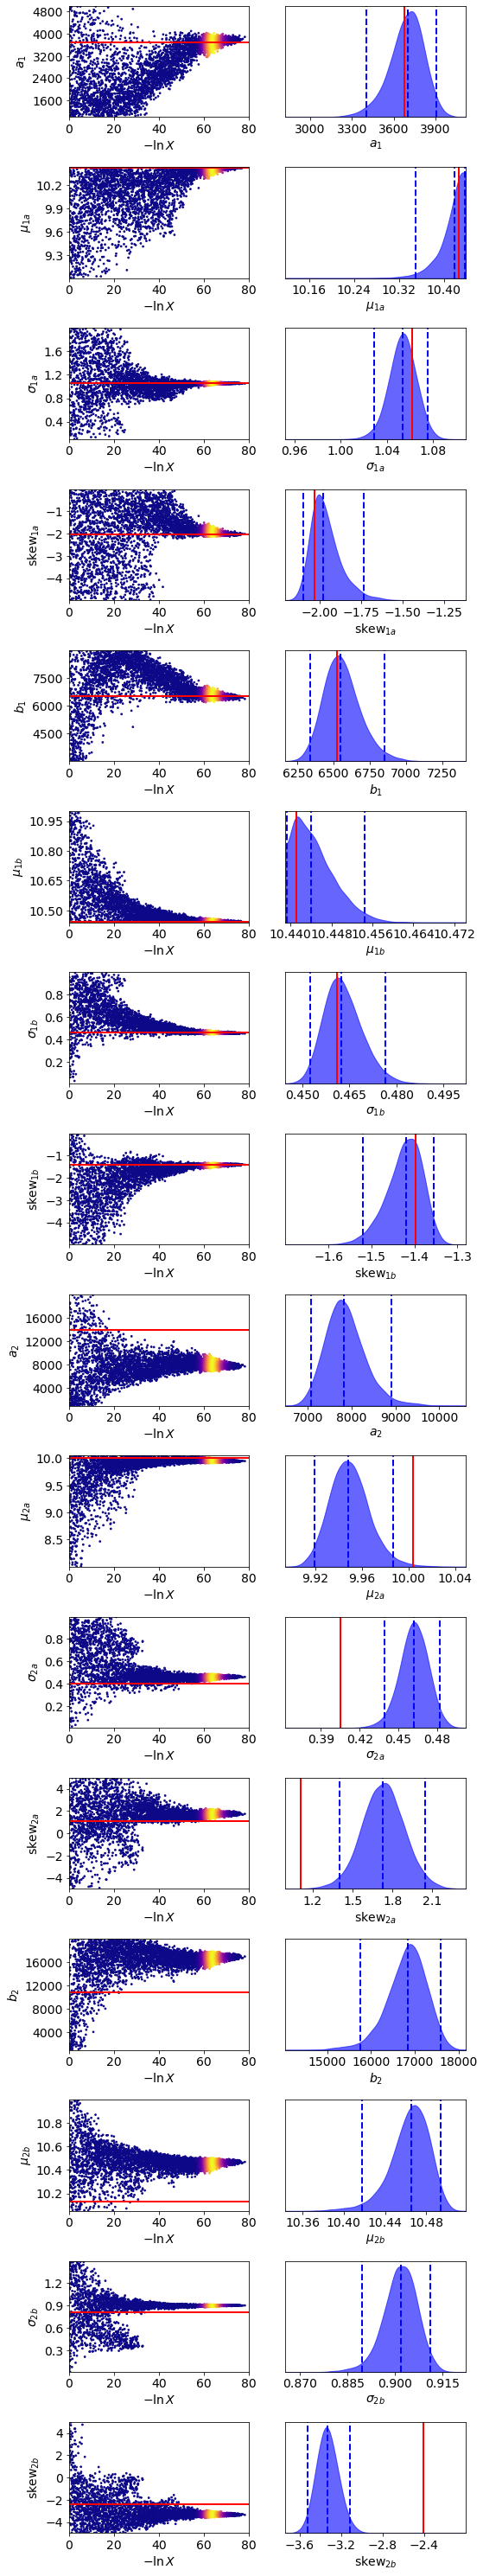

In [179]:
n_params = len(labels2_bi)

fig, axes = dyplot.traceplot(dres2_V2_Mstar, 
                             truths=V2_Mstar_bestfit2.x,
                             labels=labels2_bi, 
                             fig=plt.subplots(n_params, 2, figsize=(8, 2.6*n_params)), 
                             thin=10)

fig.tight_layout();

In [180]:
lnzM2_V2_Mstar = dres2_V2_Mstar.logz[-1]
lnzM2_V2_Mstar

-531.2106769407294

In [181]:
V2_Mstar_bestfit2_dynesty,_ = dyfunc.mean_and_cov(dres2_V2_Mstar.samples, 
                                                  np.exp(dres2_V2_Mstar.logwt - lnzM2_V2_Mstar))

V2_Mstar_bestfit2_dynesty

array([ 3.68929719e+03,  1.04127029e+01,  1.05346323e+00, -1.96192242e+00,
        6.55822496e+03,  1.04447318e+01,  4.63017609e-01, -1.42375467e+00,
        7.85558566e+03,  9.94942663e+00,  4.61909325e-01,  1.72752555e+00,
        1.68079321e+04,  1.04636354e+01,  9.01516066e-01, -3.32978416e+00])

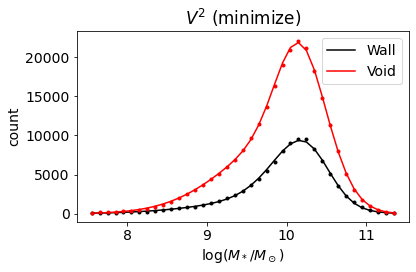

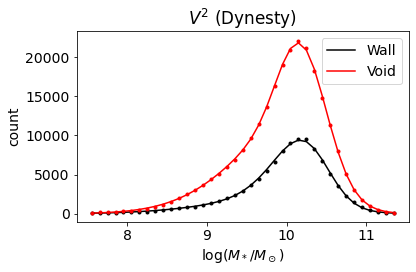

In [182]:
Model_2_plot(V2_Mstar_bestfit2.x, 
             Mstar_NSA[wall_v2], 
             Mstar_NSA[void_v2], 
             Mstar_bins, 
             2, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='$V^2$ (minimize)')

Model_2_plot(V2_Mstar_bestfit2_dynesty, 
             Mstar_NSA[wall_v2], 
             Mstar_NSA[void_v2], 
             Mstar_bins, 
             2, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='$V^2$ (Dynesty)')

##### VoidFinder

In [151]:
def prior_xform2_uni_VF(u):
    '''
    Priors for the 8 parameters of unimodel M2.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    a1 = jeffreys(1000, 10000, u[0])
    mu_a1 = uniform(9.5, 10.45, u[1])
    sigma_a1 = uniform(0.01, 2, u[2])
    skew_a1 = uniform(-5, 5, u[3])

    b1 = jeffreys(10000, 50000, u[4])
    mu_b1 = uniform(10.45, 11, u[5])
    sigma_b1 = uniform(0.1, 2, u[6])
    skew_b1 = uniform(-5, 0, u[7])
    
    a2 = jeffreys(500, 5000, u[8])
    mu_a2 = uniform(8, 10, u[9])
    sigma_a2 = uniform(0.1, 2, u[10])
    skew_a2 = uniform(-10, 0, u[11])

    b2 = jeffreys(3000, 10000, u[12])
    mu_b2 = uniform(10, 11, u[13])
    sigma_b2 = uniform(0.1, 2, u[14])
    skew_b2 = uniform(-5, 0, u[15])

    return a1, mu_a1, sigma_a1, skew_a1, b1, mu_b1, sigma_b1, skew_b1, \
           a2, mu_a2, sigma_a2, skew_a2, b2, mu_b2, sigma_b2, skew_b2

In [152]:
Model_2_sampler(prior_xform2_uni_VF, 
                Mstar_NSA[wall_vf], 
                Mstar_NSA[void_vf], 
                Mstar_bins, 
                2, 
                '_Mstar_VoidFinder')

running the nested sampler... this might take from minutes to hours...


14211it [04:10, 53.90it/s, batch: 0 | bound: 190 | nc: 80 | ncall: 333592 | eff(%):  4.254 | loglstar:   -inf < -1058.255 <    inf | logz: -1091.285 +/-  0.358 | dlogz: 289.282 >  0.010] /Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
14684it [04:21, 58.09it/s, batch: 0 | bound: 199 | nc: 25 | ncall: 349334 | eff(%):  4.197 | loglstar:   -inf < -982.519 <    inf | logz: -1016.456 +/-  0.363 | dlogz: 340.666 >  0.010]  /Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:243: UserWarning: Random walk

sampler output saved as pickle file 'dynesty_output/sampler_results_model2_Mstar_VoidFinder'


In [153]:
#temp_infile = open('dynesty_output/sampler_results_model2_gauss_Mstar_VoidFinder.pickle', 
temp_infile = open('dynesty_output/sampler_results_model2_Mstar_VoidFinder.pickle', 
                   'rb')
dres2_VF_Mstar = pickle.load(temp_infile)
temp_infile.close()

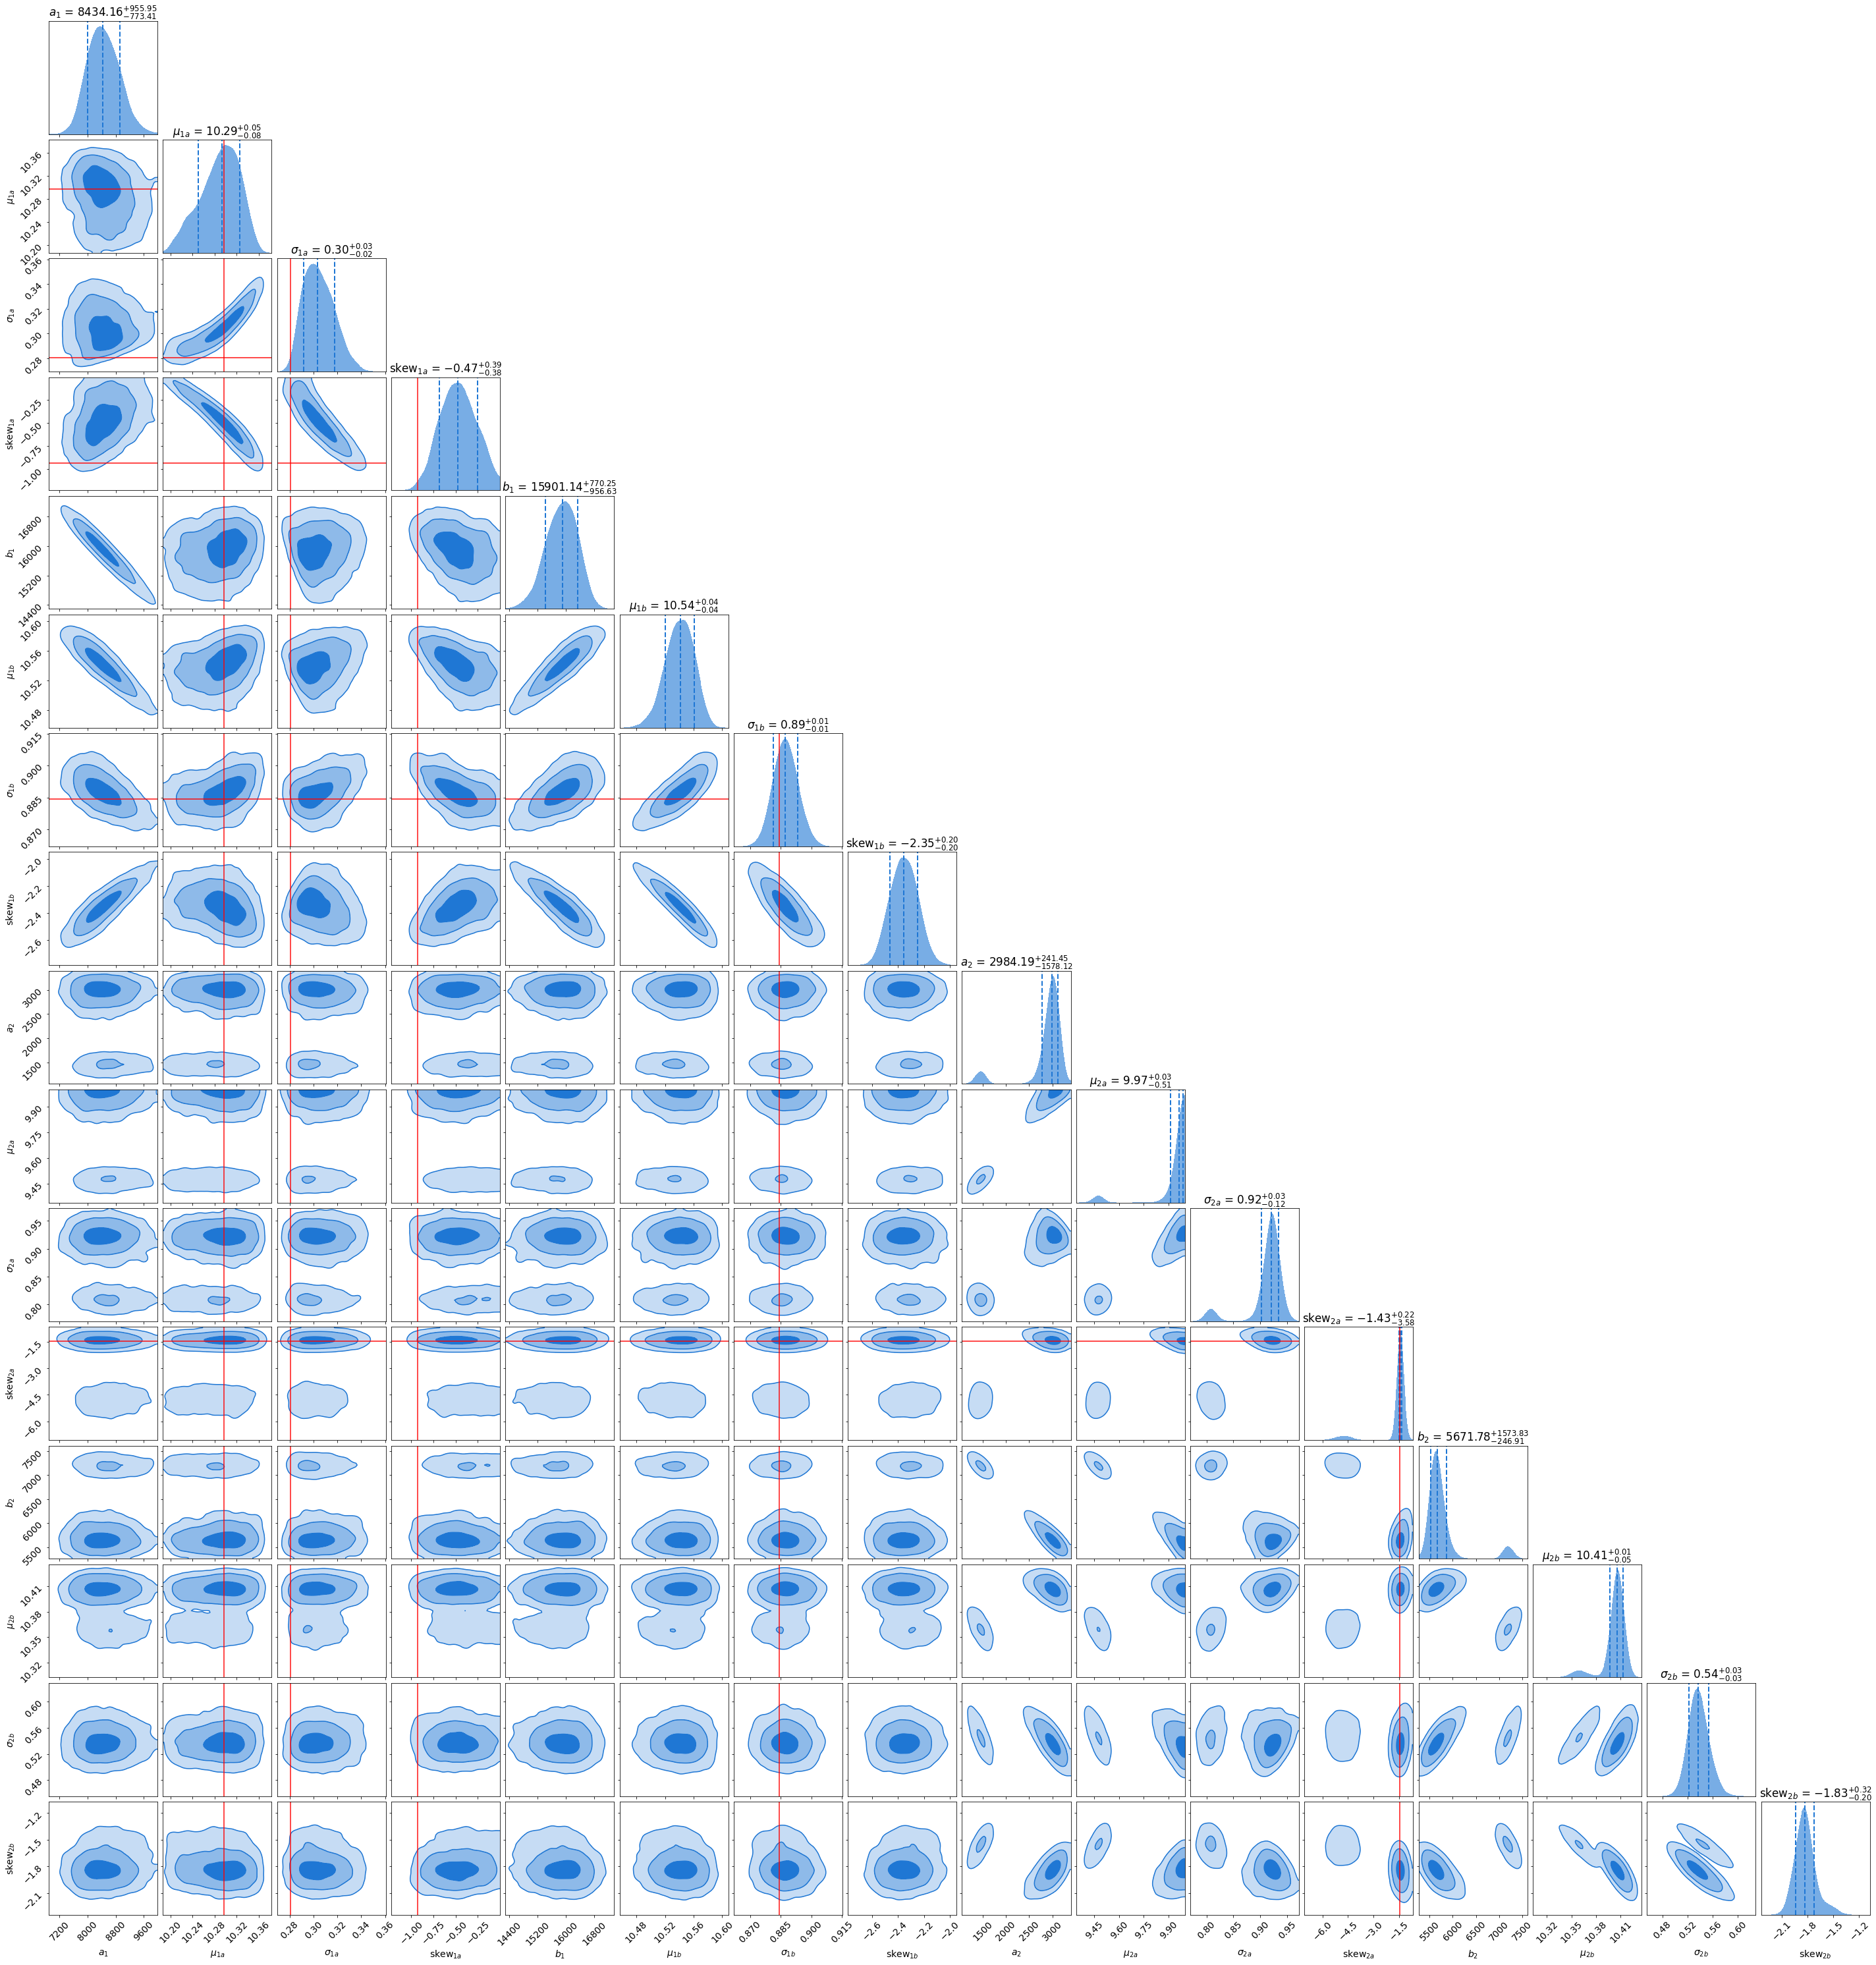

In [184]:
fig, axes = dyplot.cornerplot(dres2_VF_Mstar, smooth=0.03, 
                              labels=labels2_bi,
                              #labels=labels2_uni, 
                              truths=VF_Mstar_bestfit2.x,
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(16, 16, figsize=(2.5*16, 2.6*16)),
                              #fig=plt.subplots(8, 8, figsize=(2.5*8, 2.6*8)), 
                              color='#1f77d4')

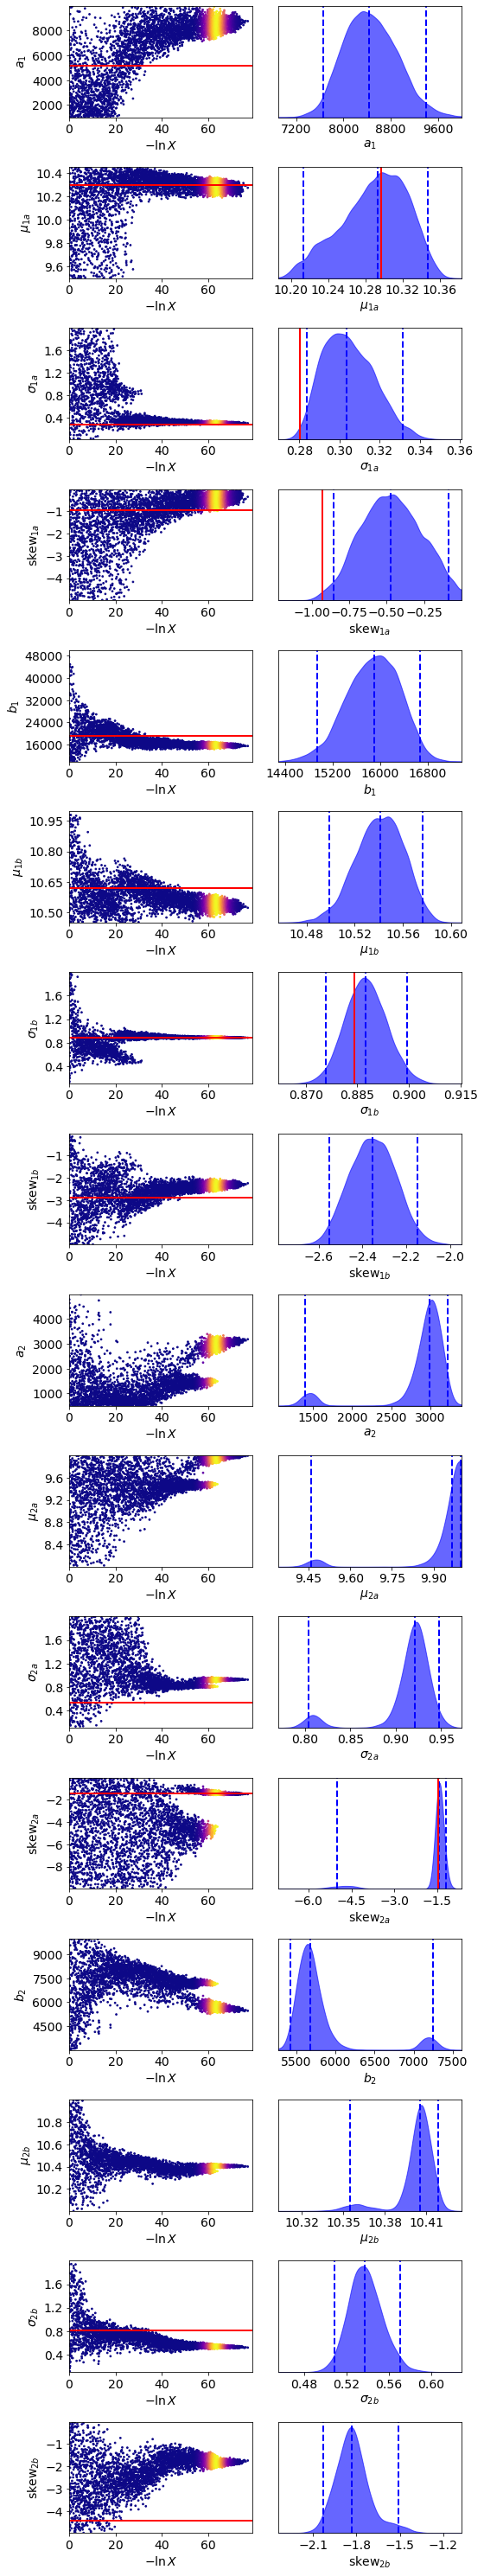

In [185]:
n_params = len(labels2_bi)

fig, axes = dyplot.traceplot(dres2_VF_Mstar, 
                             labels=labels2_bi, 
                             truths=VF_Mstar_bestfit2.x, 
                             fig=plt.subplots(n_params, 2, figsize=(8, 2.6*n_params)), 
                             thin=10)

fig.tight_layout();

In [142]:
lnzM2_VF_Mstar = dres2_VF_Mstar.logz[-1]
lnzM2_VF_Mstar

-2858.9921185330077

In [143]:
VF_Mstar_bestfit2_dynesty,_ = dyfunc.mean_and_cov(dres2_VF_Mstar.samples, 
                                                  np.exp(dres2_VF_Mstar.logwt - lnzM2_VF_Mstar))

VF_Mstar_bestfit2_dynesty

array([ 4.61029137e+03,  9.96944021e+00,  3.27416128e-01,  1.68951656e+00,
        1.95631697e+04,  1.06098021e+01,  8.88055111e-01, -2.48376551e+00,
        9.88455737e+02,  9.10456520e+00,  5.48871292e-01, -4.15524172e+00,
        7.63567427e+03,  1.03996955e+01,  6.06606857e-01, -2.48376551e+00])

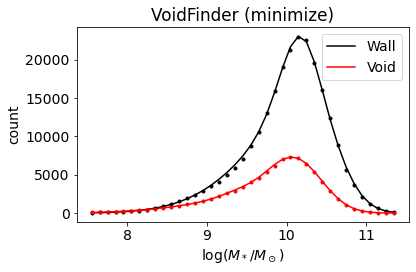

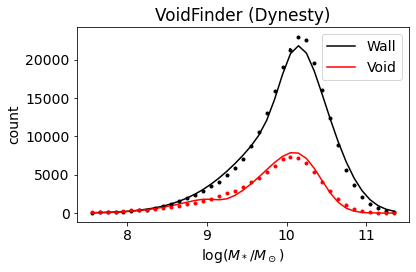

In [144]:
Model_2_plot(VF_Mstar_bestfit2.x, 
             Mstar_NSA[wall_vf], 
             Mstar_NSA[void_vf], 
             Mstar_bins, 
             2, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='VoidFinder (minimize)')

Model_2_plot(VF_Mstar_bestfit2_dynesty, 
             Mstar_NSA[wall_vf], 
             Mstar_NSA[void_vf], 
             Mstar_bins, 
             2, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='VoidFinder (Dynesty)')

## Bayes Factor

In [183]:
lnB12_V2_Mstar = lnzM1_V2_Mstar - lnzM2_V2_Mstar

B12_V2_Mstar = np.exp(lnB12_V2_Mstar)

#print('V2 Mstar: B12 = {:.3g}; log(B12) = {:.3g}'.format(B12_V2_Mstar, np.log10(B12_V2_Mstar)))
print('V2 Mstar: B12 = {:.3g}; log(B12) = {:.3f}'.format(B12_V2_Mstar, lnB12_V2_Mstar*np.log10(np.exp(1))))

V2 Mstar: B12 = 3.96e-197; log(B12) = -196.402


In [145]:
lnB12_VF_Mstar = lnzM1_VF_Mstar - lnzM2_VF_Mstar

B12_VF_Mstar = np.exp(lnB12_VF_Mstar)

#print('VoidFinder Mstar: B12 = {:.3g}; log(B12) = {:.3g}'.format(B12_VF_Mstar, np.log10(B12_VF_Mstar)))
print('VoidFinder Mstar: B12 = {:.3g}; log(B12) = {:.3f}'.format(B12_VF_Mstar, lnB12_VF_Mstar*np.log10(np.exp(1))))

VoidFinder Mstar: B12 = 0; log(B12) = -605.776


So V$^2$ overwhelmingly favors model $\mathcal{M}_1$, in which the two data sets come from the same parent distribution.

And VoidFinder overwhelmingly favors model $\mathcal{M}_2$, in which the two data sets come from different parent distributions.